In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src.data_loader import Shifted_Data_Loader
from src.plot import orig_vs_transformed as plot_ovt
from src.plot import enc_dec_samples
from src.models import GResNet,EDense
from src.config import get_config
from src.trainer import Trainer,ContrastiveTrainer
from src.utils import prepare_dirs_and_logger
from src.losses import *
from keras.datasets import fashion_mnist,mnist
from keras.layers import Dense,Input,Concatenate,Lambda,Add,Multiply
from keras.models import Model
from keras.optimizers import RMSprop
import keras.backend as K
# from tabulate import tabulate

Using TensorFlow backend.


In [2]:
config,_ = get_config()
setattr(config, 'batch_size', 500)
setattr(config, 'dataset', 'fashion_mnist')
setattr(config, 'epochs', 100)
setattr(config, 'enc_layers', [3000,2000])
setattr(config, 'dec_blocks', [4,2,1])
setattr(config, 'z_dim', 5)
setattr(config, 'y_dim', 10)
setattr(config, 'xcov', 1000)
setattr(config, 'recon', 5)
setattr(config, 'log_dir', '../logs')
setattr(config, 'dev_mode',True)
setattr(config, 'monitor', 'val_G_loss')
setattr(config, 'min_delta', 0.5)
# setattr(config, 'xcov', None)
setattr(config, 'optimizer', 'adam')

vars(config)

{'batch_size': 500,
 'data_dir': 'data',
 'dataset': 'fashion_mnist',
 'dec_blocks': [4, 2, 1],
 'dev_mode': True,
 'enc_layers': [3000, 2000],
 'epochs': 100,
 'log_dir': '../logs',
 'log_level': 'INFO',
 'min_delta': 0.5,
 'monitor': 'val_G_loss',
 'optimizer': 'adam',
 'recon': 5,
 'xcov': 1000,
 'xent': 10,
 'y_dim': 10,
 'z_dim': 5}

In [3]:
if not config.dev_mode:
    print('setting up...')
    prepare_dirs_and_logger(config)
    
    with open(os.path.join(config.model_dir,'params.json'), 'w') as fp:
        json.dump(vars(config), fp)

In [4]:
DL = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                         rotation=None,
#                          rotation=0.20,
                         translation=0.75,
                        )

input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.9
rot_max:  None
loading fashion_mnist...
sx_train:  (60000, 3136)
making training data...
making testing data...


In [5]:
G_builder = GResNet(y_dim=config.y_dim,z_dim=config.z_dim,dec_blocks=config.dec_blocks)
E_builder = EDense(enc_layers=config.enc_layers,z_dim=config.z_dim,)
trainer = ContrastiveTrainer(config,DL,Ebuilder=E_builder,Gbuilder=G_builder)
trainer.build_encoder(DL.input_shape)
# inp = Input(shape=(3136,),name='image')
# l1 = Dense(3000,activation='relu')(inp)
# l1 = Dense(2000,activation='relu')(l1)
# # l1 = Dense(300,activation='relu')(l1)
# y_lat = Dense(config.y_dim,name='y_lat')(l1)
# z_lat = Dense(config.z_dim,name='z_lat')(l1)

base_model = trainer.E

building encoder...


In [6]:
trainer.build_encoder(input_shape=DL.input_shape)

building encoder...


In [7]:
trainer.E.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 3136)         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 3000)         9411000     input_image[0][0]                
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2000)         6002000     dense_3[0][0]                    
__________________________________________________________________________________________________
class (Dense)                   (None, 10)           20010       dense_4[0][0]                    
__________________________________________________________________________________________________
z_lat (Den

In [8]:
im1 = Input(shape=(3136,),name='A')
im2 = Input(shape=(3136,),name='B')
# Y_in = Input(batch_shape=(None,1),name='Y')

# enc_y1 = base_model(im1)
# enc_y2 = base_model(im2)
class_a= trainer.E(im1)

In [9]:
trainer.build_model(DL.input_shape)

building encoder...
building decoder/generator...


In [10]:
trainer.E.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 3136)         0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 3000)         9411000     input_image[0][0]                
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2000)         6002000     dense_5[0][0]                    
__________________________________________________________________________________________________
class (Dense)                   (None, 10)           20010       dense_6[0][0]                    
__________________________________________________________________________________________________
z_lat (Den

In [11]:
trainer.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
A (InputLayer)                  (None, 3136)         0                                            
__________________________________________________________________________________________________
B (InputLayer)                  (None, 3136)         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 10), (None,  15443015    A[0][0]                          
                                                                 B[0][0]                          
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 15)           0           encoder[1][0]                    
          

In [12]:
trainer.compile_model()

In [13]:
idxs = np.random.randint(0,10000,size=100)
combos = np.array(np.meshgrid(idxs,idxs)).T.reshape(-1,2)

In [14]:
pairs = zip(combos[:,0].tolist(),combos[:,1].tolist())
combo_y = np.array([0 if DL.y_train[a]==DL.y_train[b] else 1 for a,b in pairs])
pairs = zip(combos[:,0].tolist(),combos[:,1].tolist())
combo_x = [(DL.sx_train[a],DL.sx_train[b]) for a,b in pairs]

In [15]:
x1,x2 = zip(*combo_x)
x1 = np.array([x.tolist() for x in list(x1)])
x2 = np.array([x.tolist() for x in list(x2)])

In [16]:
print(combo_y.shape)
print(x1.shape)
print(x2.shape)

(10000,)
(10000, 3136)
(10000, 3136)


In [17]:
rand_idxs = np.random.randint(0,10000,size=128)
rand_x = {'X1':x1[rand_idxs],'X2':x2[rand_idxs],'Y':combo_y[rand_idxs]}

In [18]:
mod = trainer.model
mod.targets
# K.gradients(mod.loss(mod.targets[0],mod.output),[mod.targets[0],mod.output,])

[<tf.Tensor 'G_target:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'G_target_1:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'euclidean_distance_target:0' shape=(?, ?) dtype=float32>]

In [19]:
trainer.E.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 3136)         0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 3000)         9411000     input_image[0][0]                
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2000)         6002000     dense_5[0][0]                    
__________________________________________________________________________________________________
class (Dense)                   (None, 10)           20010       dense_6[0][0]                    
__________________________________________________________________________________________________
z_lat (Den

In [20]:
trainer.model.outputs

[<tf.Tensor 'G/G_image_flat/Reshape:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'G_1/G_image_flat/Reshape:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'euclidean_distance/Sqrt:0' shape=(?, 1) dtype=float32>]

In [23]:
from src.trainer import euclidean_distance

In [69]:
def euclidean_dist_gen(u,v_arr,method='euclidean'):
    distances = {
        'euclidean':euclidean,
        'seuclidean':seuclidean
    }
    for v in tqdm(v_arr):
        yield distances[method](u,v)

def find_knn(u,dataset,k=5):
    dists = list(euclidean_dist_gen(x_tr_ex,DL.x_train))
    sorted_dists = sorted(zip(dists,range(60000)),key=lambda tup:tup[0])
    return sorted_dists[1:1+k]

def batch_gen(knn=5,num_shifts=4,):
    batch_size=knn*num_shifts

In [70]:
x_tr_idx = np.random.randint(0,60000)
x_tr_ex = DL.x_train[x_tr_idx]

In [71]:
knn = find_knn(x_tr_ex,DL.x_train,k=5)

100%|██████████| 60000/60000 [00:01<00:00, 39022.44it/s]


In [72]:
dist,idxs = zip(*knn)

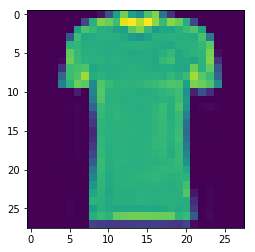

In [73]:
plt.imshow(x_tr_ex.reshape(28,28))

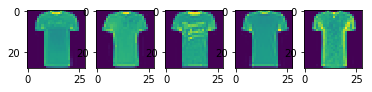

In [74]:
fig,axs = plt.subplots(1,5)
for ax,idx in zip(axs,list(idxs)):
    ax.imshow(DL.x_train[idx].reshape(28,28))

In [47]:
sorted_dists

[(0.0, 27638),
 (5.450146675109863, 20361),
 (5.567053318023682, 10187),
 (5.638850212097168, 55616),
 (5.7054338455200195, 11693),
 (5.714379787445068, 10414),
 (5.794131755828857, 55056),
 (5.818718433380127, 5625),
 (5.873557090759277, 59157),
 (6.003226280212402, 22125),
 (6.012707233428955, 3768),
 (6.074528694152832, 49524),
 (6.101979732513428, 36374),
 (6.110721588134766, 50880),
 (6.127228736877441, 20473),
 (6.13072395324707, 26840),
 (6.143731594085693, 59011),
 (6.1619439125061035, 14733),
 (6.166145324707031, 2873),
 (6.174595355987549, 38706),
 (6.206881999969482, 26696),
 (6.249919891357422, 19303),
 (6.276442050933838, 35358),
 (6.27659273147583, 53468),
 (6.278343200683594, 35769),
 (6.290780544281006, 40010),
 (6.319338798522949, 16305),
 (6.322803020477295, 31620),
 (6.324387550354004, 24909),
 (6.3491058349609375, 53449),
 (6.359380722045898, 21176),
 (6.361831188201904, 13037),
 (6.373907566070557, 46577),
 (6.397336006164551, 2622),
 (6.399506092071533, 16678),
 (

In [35]:
len(DL.x_train.tolist())

60000

In [21]:
trainer.model.fit(
    x={'A':x1,'B':x2},
    y={'euclidean_distance':combo_y.reshape(-1,1),
       'G':x1,
       'G_1':x2,},
    verbose=1,
    epochs=config.epochs,
    batch_size=config.batch_size)

Epoch 1/100
10000/10000 [==============================] - 6s 559us/step - loss: 4100.4366 - G_loss: 402.2642 - euclidean_distance_loss: 8.9987
Epoch 2/100
10000/10000 [==============================] - 2s 240us/step - loss: 1452.3827 - G_loss: 165.4667 - euclidean_distance_loss: 1.5977
Epoch 3/100
10000/10000 [==============================] - 2s 245us/step - loss: 1307.6151 - G_loss: 163.0038 - euclidean_distance_loss: 1.2080
Epoch 4/100
10000/10000 [==============================] - 2s 245us/step - loss: 1225.1043 - G_loss: 159.8741 - euclidean_distance_loss: 1.0026
Epoch 5/100
10000/10000 [==============================] - 2s 247us/step - loss: 1222.3425 - G_loss: 160.5130 - euclidean_distance_loss: 0.9269
Epoch 6/100
10000/10000 [==============================] - 2s 247us/step - loss: 1254.2453 - G_loss: 174.4783 - euclidean_distance_loss: 0.6848
Epoch 7/100
10000/10000 [==============================] - 2s 245us/step - loss: 1238.9475 - G_loss: 159.6042 - euclidean_distance_loss:

KeyboardInterrupt: 

In [ ]:
encoder = trainer.E
y_enc = encoder.predict(DL.sx_test)

In [ ]:
y_class,z_lat = y_enc

In [ ]:
plt.scatter(y_class[:,0],y_class[:,1],c=DL.y_test)

In [ ]:
# G_builder = GResNet(y_dim=config.y_dim,z_dim=config.z_dim,dec_blocks=config.dec_blocks)
# E_builder = EDense(enc_layers=config.enc_layers,z_dim=config.z_dim,)
# trainer = Trainer(config,DL,E_builder,G_builder,)

In [ ]:
pt,idx = plot_ovt(DL,cmap='gray')

In [ ]:
trainer.E.summary()

In [ ]:
# trainer.build_model()
# trainer.E.inputs
z_encoder = Model(
    trainer.E.inputs[0],
    trainer.E.get_layer(name='z_lat').output
)
classifier = Model(
    trainer.E.inputs[0],
    trainer.E.get_layer(name='class').output
)

In [ ]:
from keras.utils import to_categorical
RF = to_categorical(np.ones(len(DL.sx_train)),num_classes=2)

In [ ]:
# trainer.go(x=DL.sx_train,
#            y={'class':DL.y_train_oh,'D':RF,'G':DL.sx_train},
#            validation_split=0.05,
#            verbose=0)

In [ ]:
# DL = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
#                          rotation=0.25,
#                          translation=0.9,
#                         )

In [ ]:
hist_df = pd.DataFrame.from_records(trainer.model.history.history)
hist_df.head()

In [ ]:
sns.set_context('paper')
metrics = ['loss','G_loss','class_acc']
fig,axs = plt.subplots(nrows=len(metrics),sharex=True,figsize=(5,10))
for metric_name,ax in zip(metrics,axs):
    sns.scatterplot(data=hist_df[[metric_name,'val_'+metric_name]],ax=ax)

In [ ]:
if not config.dev_mode:
    trainer.save_model()

In [ ]:
from keras.models import Model
from keras.layers import Input

In [ ]:
generator = trainer.G

In [ ]:
# trainer.y_class

In [ ]:

# decoder_inp = Input(shape=(config.y_dim+config.z_dim,))
# dec_layers = trainer.model.layers[-(1+(5*2)):]
# print(dec_layers)
# _gen_x = dec_layers[0](decoder_inp)
# l = dec_layers[1]
# isinstance(l,keras.layers.core.Reshape)
# F = None
# for l in dec_layers[1:]:
#     print(type(l))
    
#     if isinstance(l,keras.layers.merge.Add):
#         _gen_x = l([F,_gen_x])
#     else:
#         _gen_x = l(_gen_x)
    
#     if isinstance(l,keras.layers.convolutional.Conv2DTranspose):
#         if l.kernel_size==(1,1):
#             F = _gen_x
            
# # generator = Model(decoder_inp,_gen_x)

In [ ]:
classifier.summary()

In [ ]:
DL.y_test_oh.shape

In [ ]:
classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
classifier.evaluate(DL.sx_test,DL.y_test_oh,batch_size=config.batch_size)

In [ ]:
z_enc = z_encoder.predict(DL.sx_test,batch_size=config.batch_size)
y_class = classifier.predict(DL.sx_test,batch_size=config.batch_size)

In [ ]:
_lat_vec = np.concatenate([y_class,z_enc],axis=1)
_lat_vec.shape

In [ ]:
regen = generator.predict(_lat_vec,batch_size=config.batch_size)

In [ ]:
rand_im = np.random.randint(0,10000)
plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [ ]:
enc_dec_samples(DL.x_test[outl],DL.sx_test[outl],z_enc,y_class,generator)

In [ ]:
from src.metrics import var_expl
dxs = DL.dx[1]-14
dys = DL.dy[1]-14
dtheta = DL.dtheta[1]
fve_dx = var_expl(features=z_enc,cond=dxs,bins=21)
fve_dy = var_expl(features=z_enc,cond=dys,bins=21)
fve_dt = var_expl(features=z_enc,cond=dtheta,bins=21)

In [ ]:
fve_dx_norm = np.nan_to_num((dxs.var()-fve_dx)/dxs.var())
fve_dy_norm = np.nan_to_num((dys.var()-fve_dy)/dys.var())
fve_dth_norm = (dtheta.var()-fve_dt)/dtheta.var()

In [ ]:
import seaborn as sns
sns.set_context('talk')

In [ ]:
fve_dx_norm

In [ ]:
fve_dx_norm.shape

In [ ]:
sns.scatterplot(x=fve_dx_norm.mean(axis=0),y=fve_dy_norm.mean(axis=0),hue=np.arange(config.z_dim))
plt.xlabel('fve_dx')
plt.ylabel('fve_dy')
# plt.ylim(-0.125,0.25)
xdim = np.argmax(fve_dx_norm.mean(axis=0))

In [ ]:
fve_dy_norm.mean(axis=0)

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dy_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dy')
# plt.ylim(-0.125,0.25)
ydim = np.argmax(fve_dy_norm.mean(axis=0))

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dth_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dtheta')
# plt.ylim(0.0,0.5)
np.argmax(fve_dth_norm.mean(axis=0))

In [ ]:
Z_color_scatter(z_enc,[xdim,ydim],DL.y_test)

In [ ]:
from src.plot import Z_color_scatter
Z_color_scatter(z_enc,[xdim,ydim],dxs)
# plt.ylim(-3,3)
# plt.xlim(-3,3)

In [ ]:
outl = z_enc[:,4]>5
plt.imshow(DL.sx_test[outl][np.random.randint(0,97)].reshape(56,56),cmap='gray')

In [ ]:
Z_color_scatter(z_enc,[xdim,ydim],dys)
# plt.ylim(-3,3)
# plt.xlim(-3,3)

In [ ]:
z_enc.shape

In [ ]:
sns.jointplot(dtheta,z_enc[:,4])

In [ ]:
Z_color_scatter(z_enc,[xdim,ydim],dtheta)

In [ ]:
from plt.